In [1]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt
import json
import time

<h3> SIFT Transform for Image Registration </h3><br>
<body>
    <b>ref_img</b>          : Reference Image in Numpy array (CV2)<br>
    <b>train_img</b>        : Image which you want to align<br>
    <b>blur_val</b>         : A gaussian blur filter size. (Note -: Must be Odd)<br>
    <b>dist_val</b>         : SIFT parameter to select matches in certain distance<br>
    <b>MIN_MATCH_COUNT</b>  : Minimum matches to be need to get aligned image. <br>&nbsp&nbsp&nbsp&nbsp&nbsp&nbsp If matches are less than certain value, image registraion homography fails which is needed to transform train_img<br>
    <b>show_match</b>       : If True shows the image plot of feature match
</body>

In [2]:
def sift_transform(ref_img,train_img,blur_val=7,dist_val=0.9,MIN_MATCH_COUNT = 40,show_match=True):
    ratio_blur = train_img.shape[0]/ref_img.shape[0]
    blur_t = blur_val * ratio_blur
    blur_t_odd = int(blur_val/2)*2 + 1
    ref_img = cv2.GaussianBlur(ref_img,(blur_val,blur_val),0)
    train_img = cv2.GaussianBlur(train_img,(blur_t_odd,blur_t_odd),0)
    if ref_img.shape[2] == 3:
        ref_img_gray = cv2.cvtColor(ref_img,cv2.COLOR_BGR2GRAY)
        train_img_gray = cv2.cvtColor(train_img,cv2.COLOR_BGR2GRAY)
    else:
        ref_img_gray = ref_img
        train_img_gray = train_img
    height,width = ref_img_gray.shape
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(ref_img_gray,None)
    kp2, des2 = sift.detectAndCompute(train_img_gray,None)
    print(kp1[0],des1)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 500)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    #print((matches))
    for m,n in matches:
        if m.distance < dist_val*n.distance:
            good.append(m)
    print(len(good))
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M1, mask1 = cv2.findHomography(dst_pts , src_pts, cv2.RANSAC,5.0)
        transformed_img = cv2.warpPerspective(train_img,M1, (width, height))
        transformed_img_gray = cv2.warpPerspective(train_img_gray,M1, (width, height))
        if show_match == True:
            M, mask = cv2.findHomography(src_pts,dst_pts , cv2.RANSAC,5.0)
            matchesMask = mask.ravel().tolist()
            pts = np.float32([ [0,0],[0,height-1],[width-1,height-1],[width-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)
            ref_img_gray_p = cv2.polylines(ref_img_gray,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
    if show_match:
        draw_params = dict(matchColor = (0,255,0), singlePointColor = None,matchesMask = matchesMask, flags = 2)
        match_img = cv2.drawMatches(ref_img_gray_p,kp1,train_img_gray,kp2,good,None,**draw_params)
    else:
        match_img = None
    return transformed_img,transformed_img_gray,ref_img_gray,match_img,M1,(width, height)

<h3> Kmean Function for Gray Layer </h3>
<b>K</b> : k parameter in kmeans

In [3]:
def kmean(ref_img,K=1):
    #print(K)
    Z = ref_img.reshape((-1,1))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((ref_img.shape))
    return res2,center

<h3> Adjusts Centers of Reference Image with Train Image </h3>
<b>cts</b> : List of centers created usin kmean()

In [4]:
def get_center_img_kmean(train_img,cts):
    print(cts)
    m,n,o = cts[0].shape[0],cts[1].shape[0],cts[2].shape[0]
    train_b = train_img[:,:,0]
    train_g = train_img[:,:,1]
    train_r = train_img[:,:,2]
    bs = (train_img.shape[0],train_img.shape[1])
    final_img = np.zeros(train_img.shape,dtype=np.uint8)
    p = [0]
    q = [0]
    r = [0]
    for i in range(0,m-1):
        p.append(int((int(cts[0][i,0])+int(cts[0][i+1,0]))/2))
    for i in range(0,n-1):
        q.append(int((int(cts[1][i,0])+int(cts[1][i+1,0]))/2))
    for i in range(0,o-1):
        r.append(int(int((cts[2][i,0])+int(cts[2][i+1,0]))/2))
    p.append(256)
    q.append(256)
    r.append(256)
    p.sort()
    q.sort()
    r.sort()
    cc=0
    print(p,q,r)
    #print(m,n,o,len(p),len(q),len(r))
    for i in range(m):
        temp_mask = get_temp_mask(train[:,:,0],p[i],p[i+1])
        print(p[i],p[i+1])
        #plt.imshow(temp_mask)
        final_img[:,:,0] += np.uint8(temp_mask*cts[0][i,0])
        cv2.imwrite(str(cc)+'.png',temp_mask*255)
        cc+=1
    for i in range(n):
        temp_mask = get_temp_mask(train[:,:,1],q[i],q[i+1])
        print(q[i],q[i+1])
        #plt.imshow(temp_mask)
        final_img[:,:,1] += np.uint8(temp_mask*cts[1][i,0])
        cv2.imwrite(str(cc)+'.png',temp_mask*255)
        cc+=1
    for i in range(o):
        temp_mask = get_temp_mask(train[:,:,2],r[i],r[i+1])
        print(r[i],r[i+1])
        #plt.imshow(temp_mask)
        final_img[:,:,2] += np.uint8(temp_mask*cts[2][i,0])
        cv2.imwrite(str(cc)+'.png',temp_mask*255)
        cc+=1
    return final_img

    '''
    for i in range(m):    
        temp_mask = np.zeros(bs,dtype=np.uint8)
        temp_mask = (train_img[:,:,0]>=p[i]) | (train_img[:,:,0]<p[i+1])
        print(p[i],p[i+1])
        plt.imshow(temp_mask)
        final_img[:,:,0] += temp_mask*cts[0][i,0]
    i=0
    for i in range(n):    
        temp_mask = np.zeros(bs,dtype=np.uint8)
        temp_mask = (train_img[:,:,1]>=q[i]) | (train_img[:,:,1]<q[i+1])
        final_img[:,:,1] += temp_mask*cts[1][i,0]
    for i in range(o):    
        temp_mask = np.zeros(bs,dtype=np.uint8)
        temp_mask = (train_img[:,:,2]>=q[i]) | (train_img[:,:,2]<q[i+1])
        final_img[:,:,2] += temp_mask*cts[2][i,0]
    return np.uint8(final_img)
'''
def get_temp_mask(train_layer,mink,maxk):
    mask = np.zeros(train_layer.shape,dtype=np.uint8)
    b1 = np.greater_equal(train_layer,mink)
    b2 = np.less(train_layer,maxk)
    mask = np.bitwise_and(b1,b2)*1
    return mask

<h3> Gets Probability of all components labeled with labeelme too </h3>
<b>sub_img      :</b> Image to calculate probability <br>
<b>data_json    :</b> Labeled data in json format<br>
<b>xor_bool     :</b> If true applies otsu threshold<br>

In [5]:
def get_fail(sub_img,data_json,xor_bool=False,image_scale=0.5):
    if xor_bool == True:
        sub_img_g,otsu_sub_img = cv2.threshold(sub_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        print('Otsu Threshold : ',sub_img_g)
    else:
        otsu_sub_img = sub_img
    probs = []
    for i in data_json['shapes']:
        mask = np.zeros(otsu_sub_img.shape)
        ptrs = np.array(np.array(i['points'])*image_scale,dtype=np.int32)
        mask = cv2.fillPoly(mask, pts=[ptrs], color=(255))
        mask_sub = np.bitwise_and(otsu_sub_img.astype(np.uint8),mask.astype(np.uint8))
        prob = np.sum(mask_sub)/np.sum(mask)
        probs.append(prob)
        print(i['label'],' -> ',prob)
        #print(i)
    return probs

<h3>Creates Mask</h3>
<b>color</b> : Used to define Shape

In [6]:
def create_mask(ref_img,data_json,color='gray',image_scale=0.5):
    if(color == 'gray'):
        mask = np.zeros(ref_img.shape[0:2])
    else:
        mask = np.zeros(ref_img.shape)
    for i in data_json['shapes']:
        ptrs = np.array(np.array(i['points'])*image_scale,dtype=np.int32)
        mask = cv2.fillPoly(mask, pts=[ptrs], color=(255, 255, 255))
        #print(i)
    return mask

<h3>Creates polygons and Writes Probability with Compare Options</h3>
<b>probs       :</b> List of Probabilities<br>
<b>prob_disp   :</b> If True Displat Probabilitiesv
<b>prob_cmp    :</b> Compare with probability, if probability is greater than prob_cmp it displays<br>
<b>thickness   :</b> Thickness of Polylines<br>
<b>color_val   :</b> Polyline Color (BGR)<br>
<b>color_text  :</b> Text Color (BGR)<br>

In [7]:
def create_polyline_prob(ref_img,data_json,probs = [],probs_disp = False,prob_cmp=0,color='gray',image_scale=0.5,thickness=2,color_val=(0,255,0),color_text=(0,0,255)):
    try:
        ref_img.shape[2]
    except:
        ref_img = cv2.cvtColor(ref_img,cv2.COLOR_GRAY2BGR)
    c = -1
    for i in data_json['shapes']:
        c+=1
        ptrs = np.array(np.array(i['points'])*image_scale,dtype=np.int32)
        ref_img = cv2.polylines(ref_img, [ptrs],True, color_val, thickness)
        if(probs_disp and probs[c]>prob_cmp):
            org = (int(ptrs[0][0]),int(ptrs[0][1])-5)
            ref_img = cv2.putText(ref_img, str(round(probs[c],2)), org, cv2.FONT_HERSHEY_SIMPLEX,1*image_scale, color_text, 2, cv2.LINE_AA)
        #print(i)
    return ref_img

<b> Read Images </b>

(561, 986, 3)


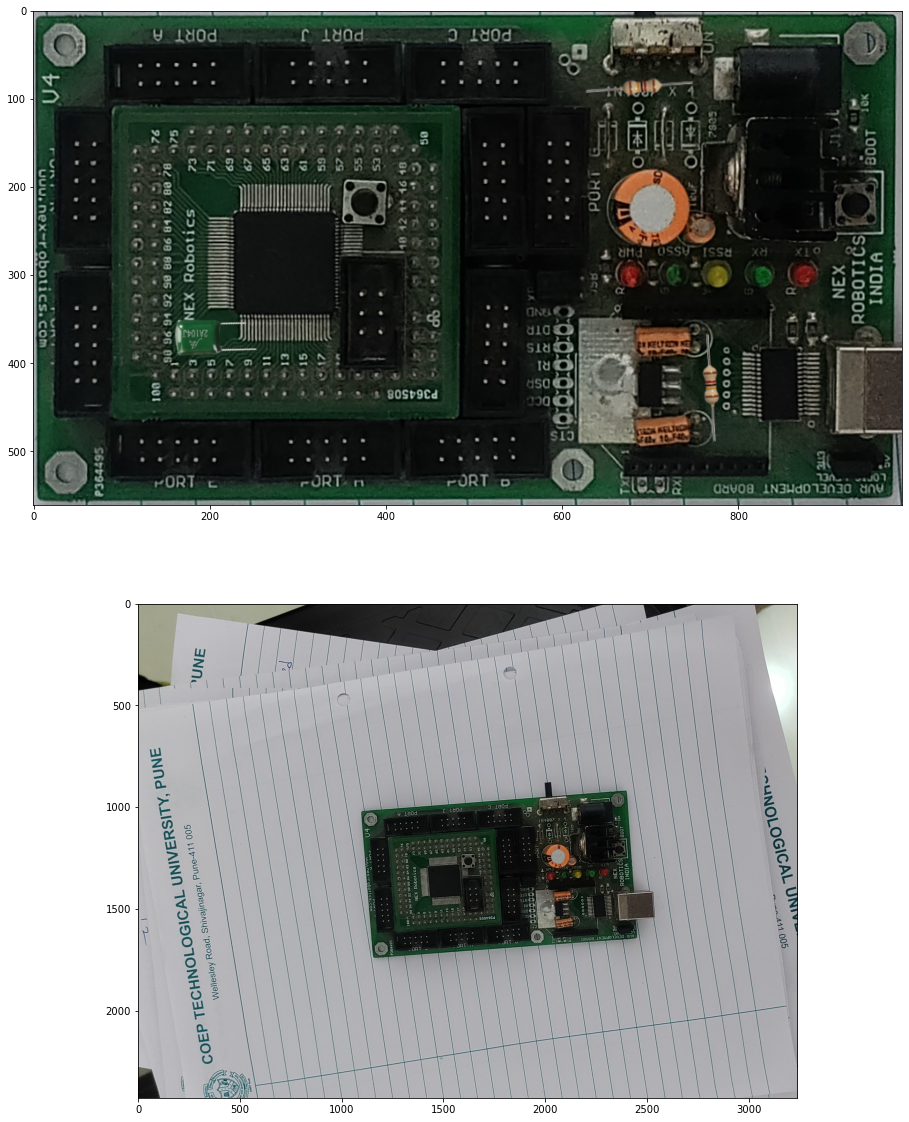

In [18]:
#ref = cv2.imread('/home/sam/PCB/master/images/setup/images/arduino/ref/arduino_ref.png')
#train = cv2.imread('/home/sam/PCB/master/images/setup/images/arduino/train/5.jpg')
#data = json.load(open('/home/sam/PCB/master/images/setup/images/arduino/ref/arduino_ref.json'))
ref = cv2.imread('/home/sam/PCB/master/images/mega2560/ref/ref_cp.png')
train = cv2.imread('/home/sam/PCB/master/images/mega2560/train/1.png')
data = json.load(open('/home/sam/PCB/master/images/mega2560/ref/ref_cp.json'))
n = 1
ref = cv2.resize(ref,(int(ref.shape[1]/n),int(ref.shape[0]/n)))
print(ref.shape)
f, axarr = plt.subplots(2,1,figsize=(20, 20))
axarr[0].imshow(ref[:,:,::-1])
axarr[1].imshow(train[:,:,::-1])

<b>Apply Kmeans</b>

[[ 14]
 [ 36]
 [ 63]
 [104]
 [150]] [[ 15]
 [ 45]
 [ 73]
 [114]
 [155]] [[ 13]
 [ 33]
 [ 67]
 [111]
 [156]]


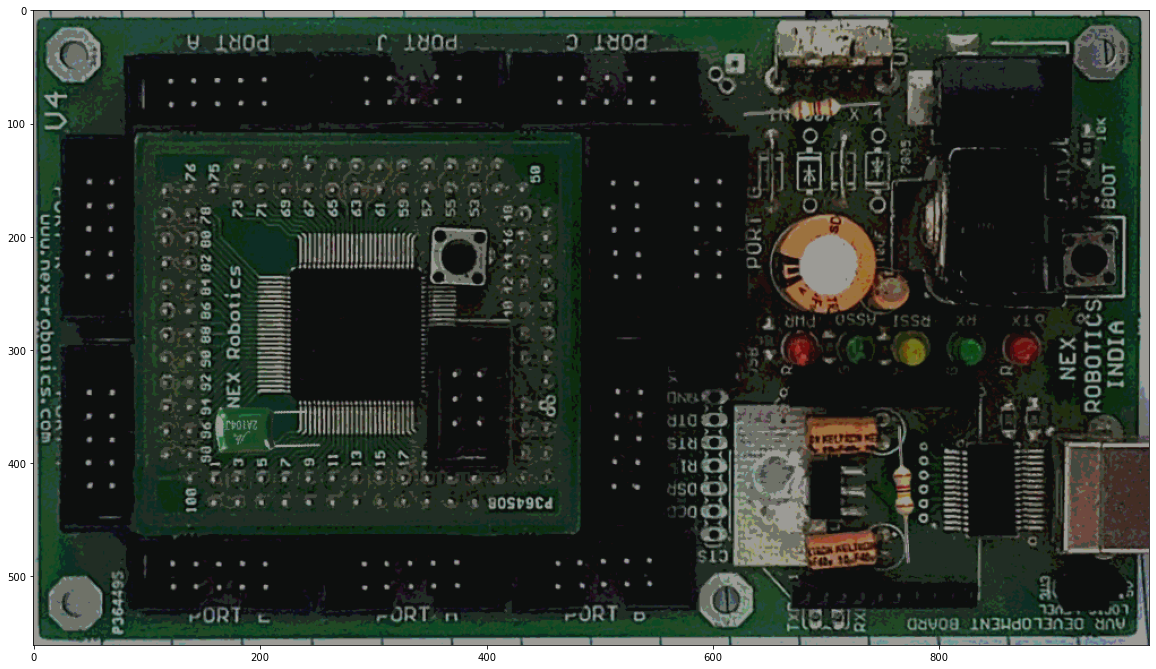

In [19]:
refk = np.zeros(ref.shape,dtype=np.uint8)
refk[:,:,0],cts1 = kmean(ref[:,:,0],5)
refk[:,:,1],cts2 = kmean(ref[:,:,1],5)
refk[:,:,2],cts3 = kmean(ref[:,:,2],5)
cv2.imwrite('kmean_ref.png',refk)
cts1 = np.sort(cts1,axis=0)
cts2 = np.sort(cts2,axis=0)
cts3 = np.sort(cts3,axis=0)
print(cts1,cts2,cts3)
f, axarr = plt.subplots(1,1,figsize=(20, 20))
axarr.imshow(refk[:,:,::-1])

<b> Use Same centers for train image</b>

[array([[ 14],
       [ 36],
       [ 63],
       [104],
       [150]], dtype=uint8), array([[ 15],
       [ 45],
       [ 73],
       [114],
       [155]], dtype=uint8), array([[ 13],
       [ 33],
       [ 67],
       [111],
       [156]], dtype=uint8)]
[0, 25, 49, 83, 127, 256] [0, 30, 59, 93, 134, 256] [0, 23, 50, 89, 133, 256]
0 25
25 49
49 83
83 127
127 256
0 30
30 59
59 93
93 134
134 256
0 23
23 50
50 89
89 133
133 256


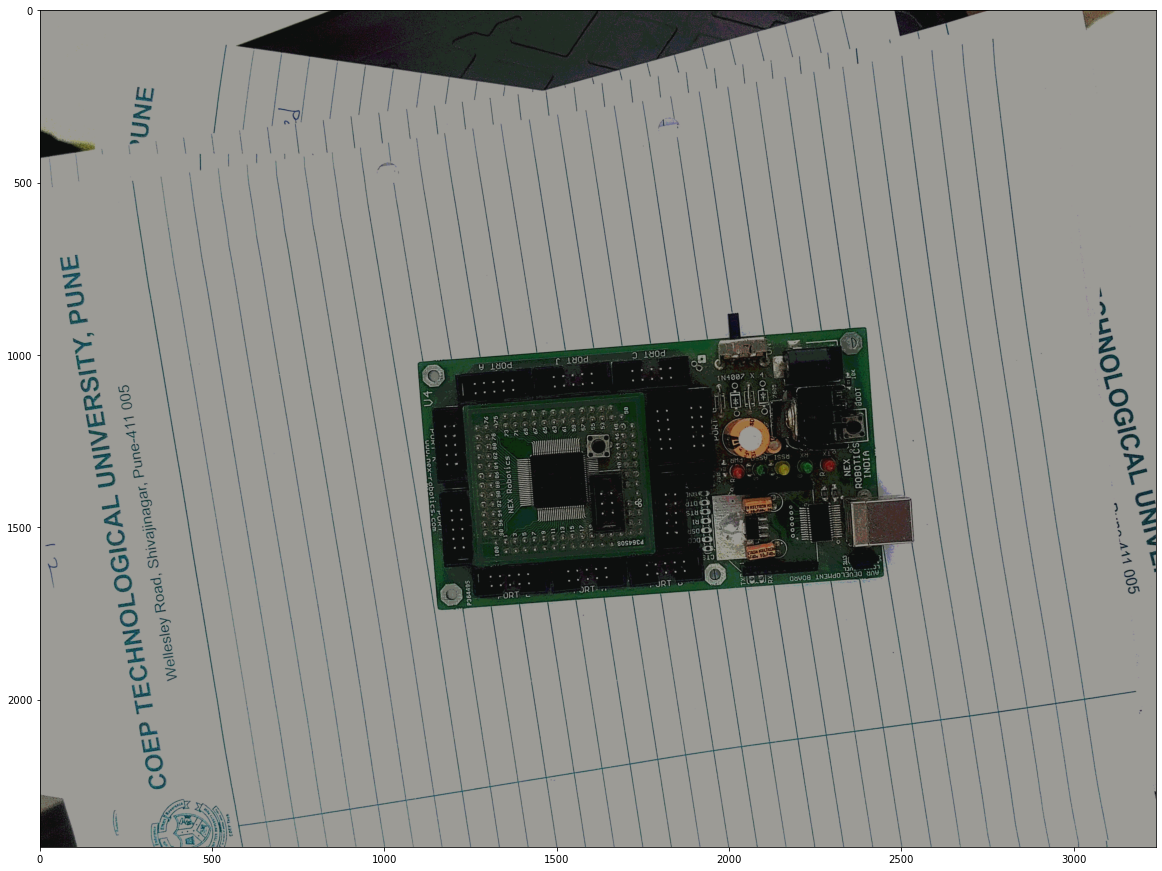

In [20]:
traink = get_center_img_kmean(train,[cts1,cts2,cts3])
f, axarr = plt.subplots(1,1,figsize=(20, 20))
axarr.imshow(traink[:,:,::-1])

<b> Apply SIFT Image Registraion </b>

< cv2.KeyPoint 0x7fc27d384c30> [[ 24.  54.  44. ...   0.   0.   0.]
 [116.  44.   1. ...   0.   0.   0.]
 [143.   8.   0. ...   0.   0.   0.]
 ...
 [ 35.   5.   0. ...  32.   4.  17.]
 [ 15.  15.  18. ...   1.   0.  27.]
 [ 65.  30.  19. ...   8.   0.   0.]]
695


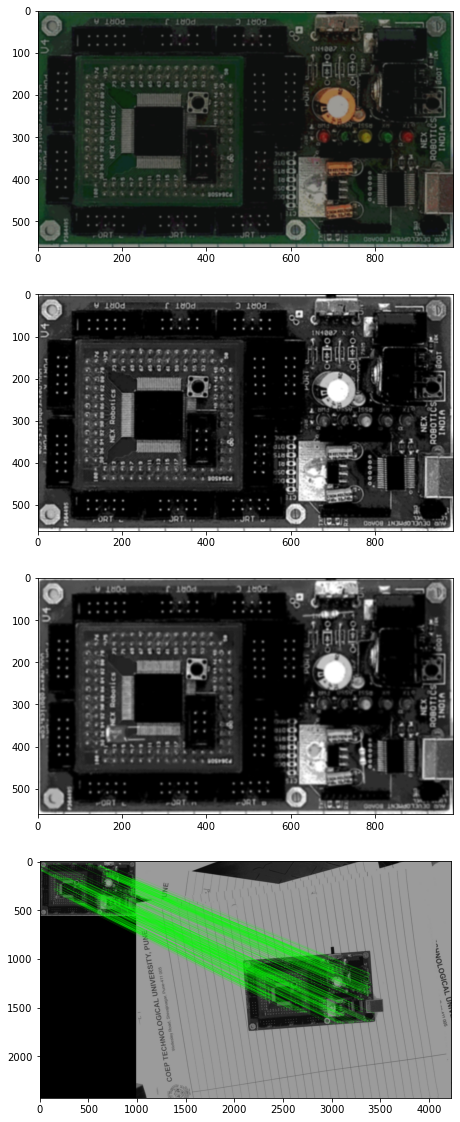

In [21]:
t_i,t_i_g,ref_g,m_i,M_warp,dim = sift_transform(refk,traink,blur_val = 11)
f, axarr = plt.subplots(4,1,figsize=(20, 20))
axarr[0].imshow(t_i[:,:,::-1])
axarr[1].imshow(t_i_g,'gray')
axarr[2].imshow(ref_g,'gray')
axarr[3].imshow(m_i)

<b>Test Ostu Thresholds</b>

Reference Threshold : 65.0
Train Threshold     : 65.0


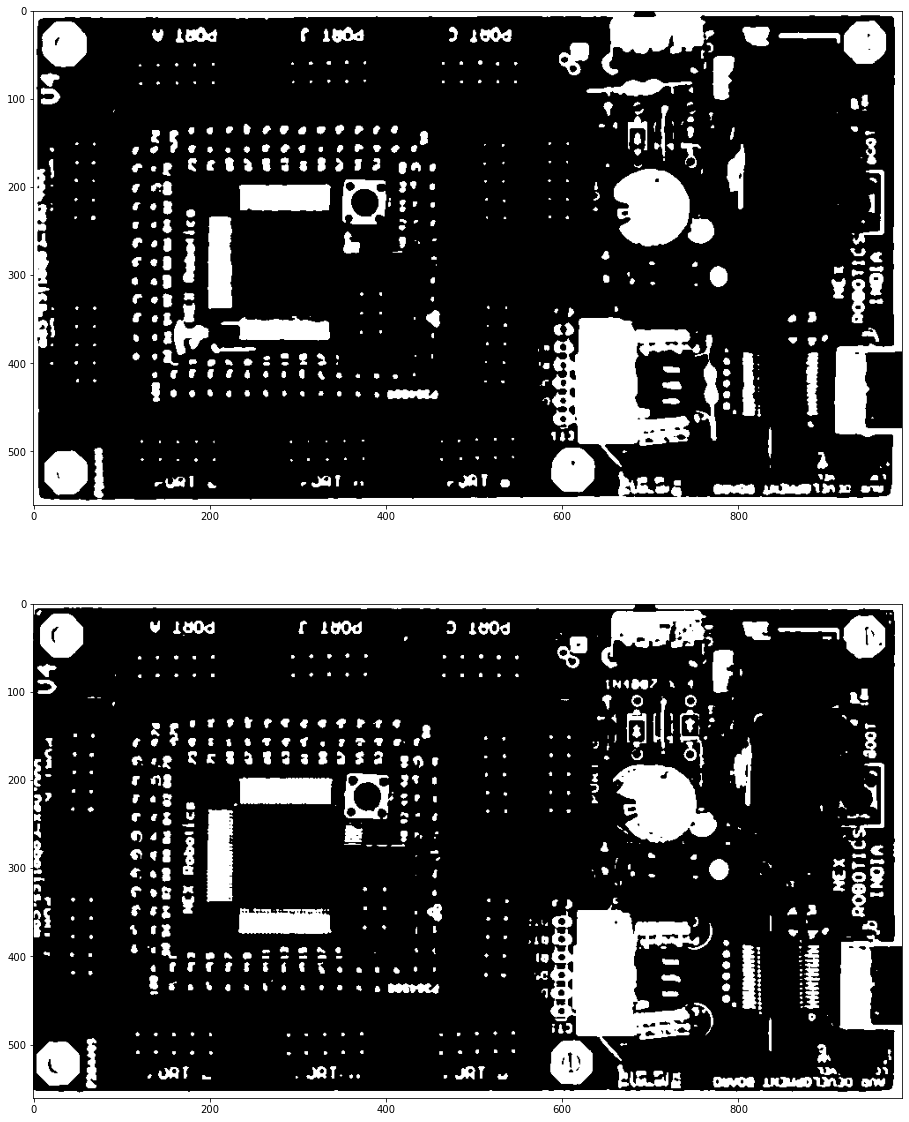

In [22]:
ref_g_thresh,otsu_ref_g = cv2.threshold(ref_g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
train_g_thresh,otsu_train_g = cv2.threshold(t_i_g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print('Reference Threshold :',ref_g_thresh)
print('Train Threshold     :',train_g_thresh)
f, axarr = plt.subplots(2,1,figsize=(20, 20))
axarr[0].imshow(otsu_ref_g,'gray')
axarr[1].imshow(otsu_train_g,'gray')

<b> Threshold the image to remove noise </b>

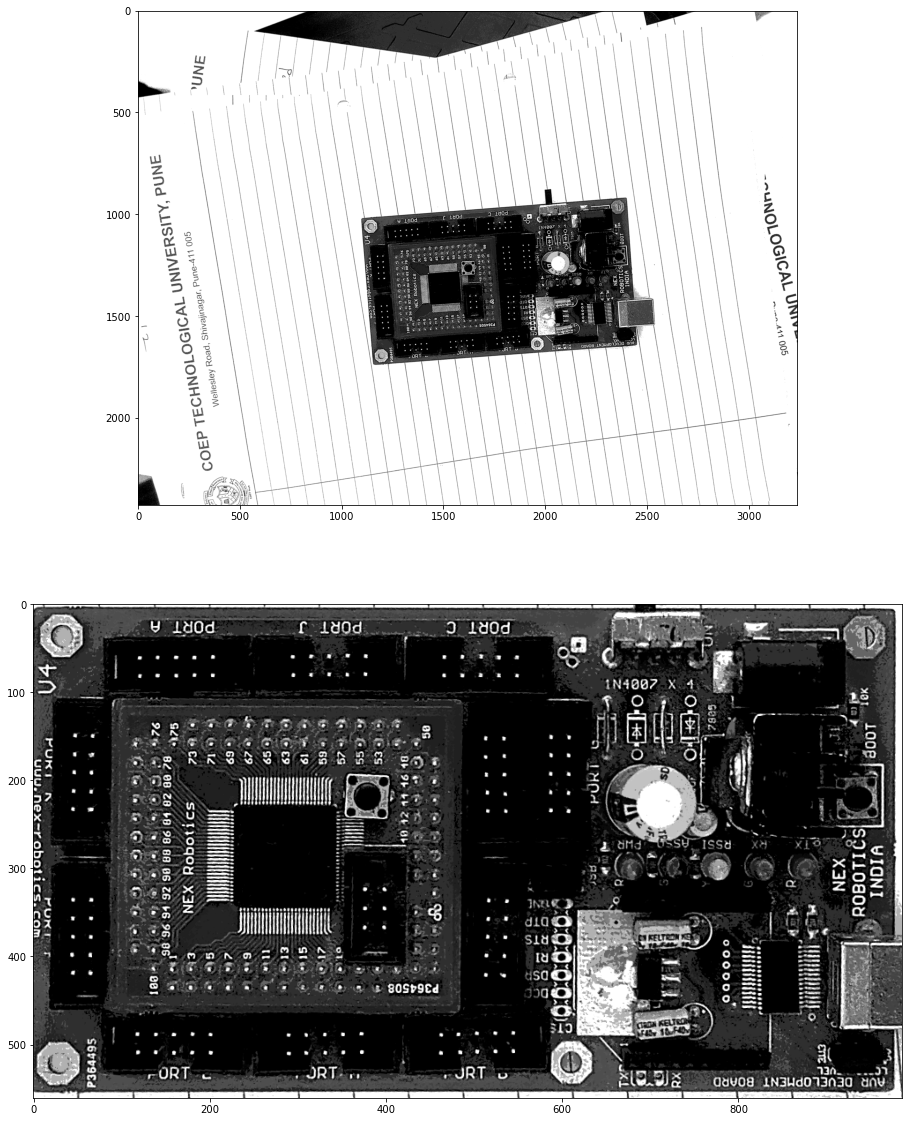

In [23]:
traink_thresh = np.uint8(cv2.cvtColor(traink,cv2.COLOR_BGR2GRAY))+int(ref_g_thresh-train_g_thresh)
traink_threshold_warp = np.uint8(cv2.warpPerspective(traink_thresh,M_warp,dim))
f, axarr = plt.subplots(2,1,figsize=(20, 20))
axarr[0].imshow(traink_thresh,'gray')
axarr[1].imshow(traink_threshold_warp,'gray')

<b>Image Subtraction</b>

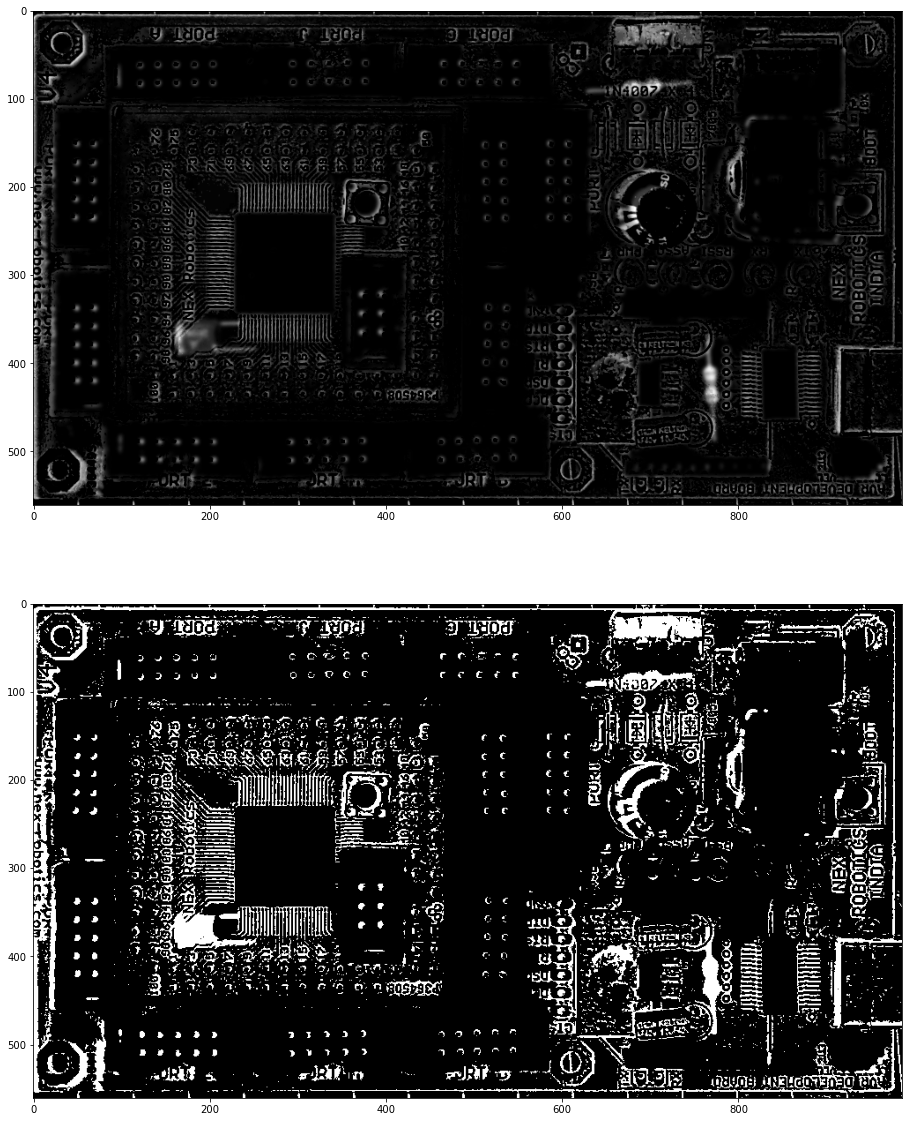

In [24]:
sub_abs = np.abs(cv2.subtract(ref_g,traink_threshold_warp))
sub_abs_exp = np.uint8(np.exp(sub_abs/255) * 0.93)
f, axarr = plt.subplots(2,1,figsize=(20, 20))
axarr[0].imshow(sub_abs,'gray')
axarr[1].imshow(sub_abs_exp,'gray')

<b> Otsu on Image Subtraction </b>

Subtraction Threshold             :  24.0
Subtraction Exponential Threshold :  0.0


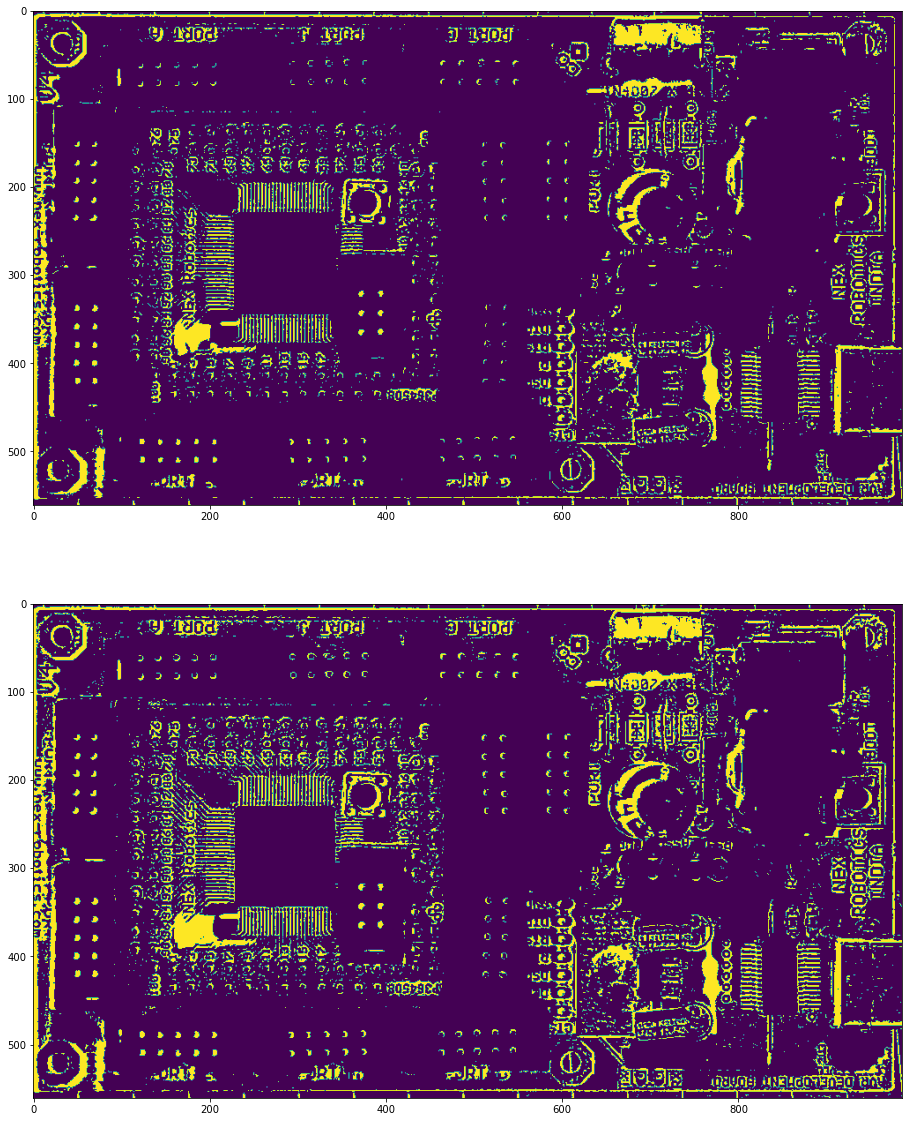

In [25]:
sub_abs_g,otsu_sub_abs = cv2.threshold(sub_abs, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
sub_abs_exp_g,otsu_sub_abs_exp = cv2.threshold(sub_abs_exp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
f, axarr = plt.subplots(2,1,figsize=(20, 20))
print('Subtraction Threshold             : ',sub_abs_g)
print('Subtraction Exponential Threshold : ',sub_abs_exp_g)
axarr[0].imshow(otsu_sub_abs)
axarr[1].imshow(otsu_sub_abs_exp)

<b> Create Masks </b>

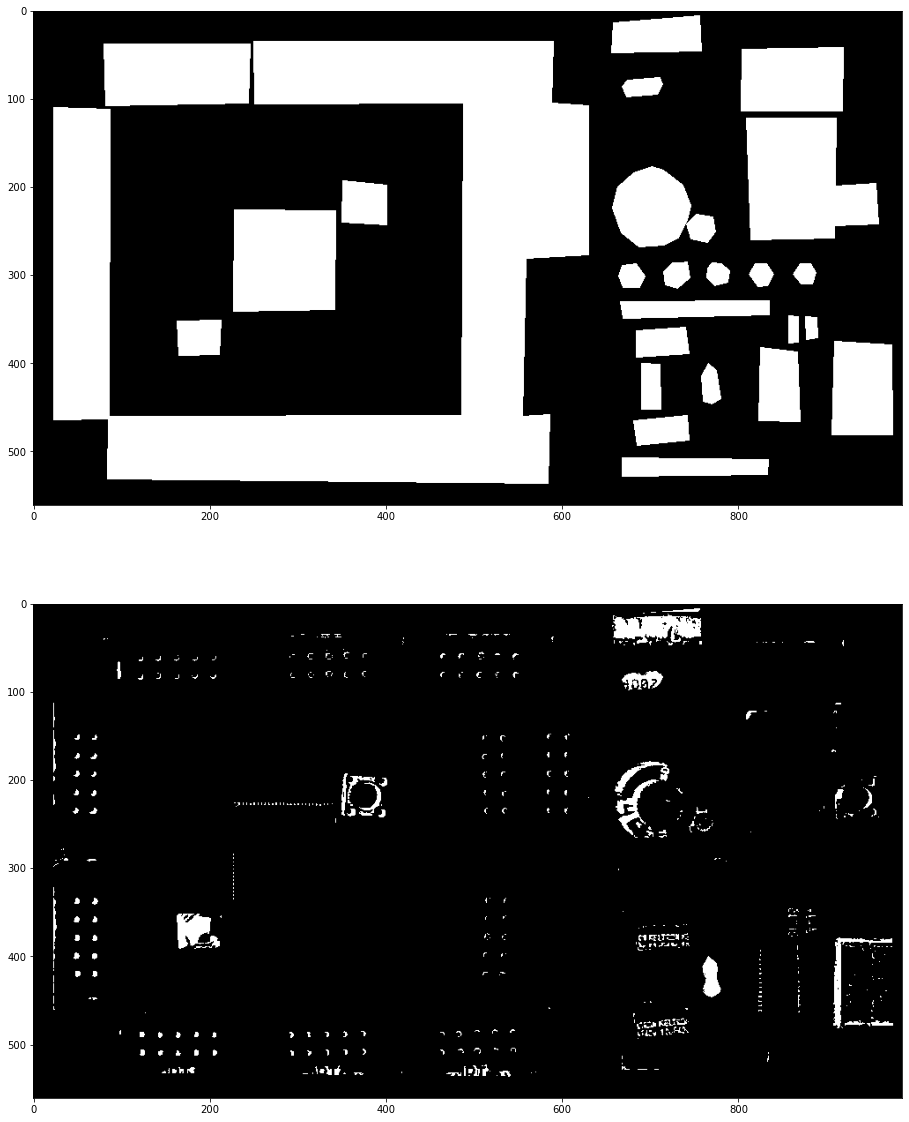

In [26]:
MASK = create_mask(ref,data,image_scale=1/n)
mask_sub = np.bitwise_and(otsu_sub_abs.astype(np.uint8),MASK.astype(np.uint8))
f, axarr = plt.subplots(2,1,figsize=(20, 20))
axarr[0].imshow(MASK,'gray')
axarr[1].imshow(mask_sub,'gray')

<b> Display Results </b>

MCU  ->  0.009186055266922672
Switch  ->  0.31216494845360826
Switch  ->  0.6145426114151681
RES  ->  0.6823671497584541
RES  ->  0.8484455958549223
CAP  ->  0.2267318663406683
CAP  ->  0.17111716621253406
CAP  ->  0.187010078387458
POWER_JACK  ->  0.005987306909352174
VR_BASE  ->  0.006189921351587533
Switch  ->  0.1118421052631579
IC  ->  0.027345844504021447
RES  ->  0.12365591397849462
RES  ->  0.10893854748603352
CAP  ->  0.12727272727272726
LED  ->  0.0030120481927710845
LED  ->  0.0
LED  ->  0.01282051282051282
LED  ->  0.0
LED  ->  0.0
IC  ->  0.004233700254022015
BUSB  ->  0.16535984318118174
CON  ->  0.01595605545383207
CON  ->  0.02295282826220135
CON  ->  0.0003204101249599487
CON  ->  0.015315315315315315
CAP  ->  0.6086734693877551


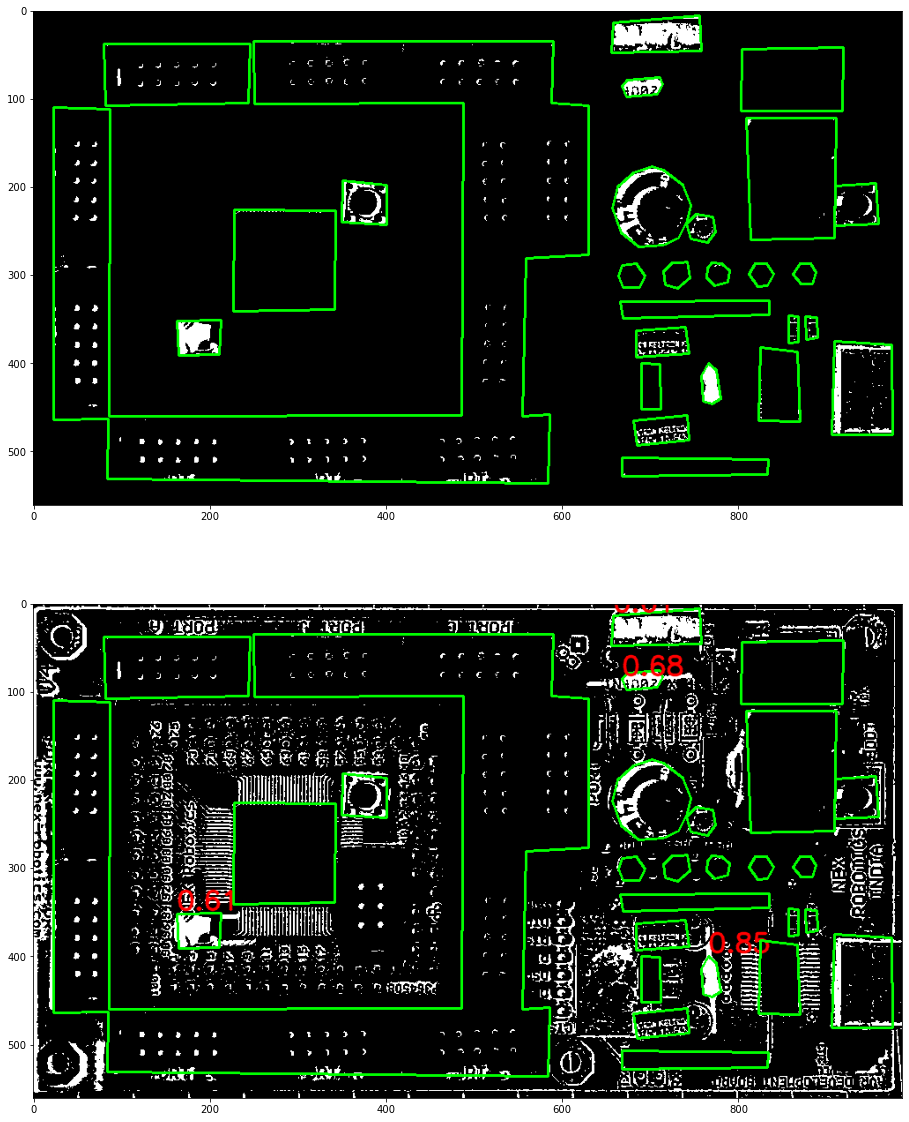

In [28]:
mask_poly = create_polyline_prob(mask_sub,data,image_scale=1/n)
P = get_fail(otsu_sub_abs,data,xor_bool=False,image_scale=1/n)
mask_poly_prob = create_polyline_prob(otsu_sub_abs,data,P,probs_disp = True,prob_cmp=0.5,image_scale=1/n)
f, axarr = plt.subplots(2,1,figsize=(20, 20))
axarr[0].imshow(mask_poly)
axarr[1].imshow(mask_poly_prob[:,:,::-1])